In [2]:
from sklearn.linear_model import LinearRegression
import numpy as np
from source.Tools import setup_device_and_seed
from source.Cross_Validation import  visualize_timeseries_splits, get_time_series_splits
# from source.Cross_Validation import backtesting_CV
from source.prepare_data import load_and_preprocess_data
from source.join_qh_min_data import join_qh_min_data
from source.features_selection import get_feature_lag_config
from B_wrappers.SBS import run_sbs
import time
from comparison_elia import compare_with_elia_preds
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from time import perf_counter
from sklearn.base import clone
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.model_selection import TimeSeriesSplit
import joblib
n_cores = joblib.cpu_count()
from sklearn.model_selection import TimeSeriesSplit
from time import perf_counter

import numpy as np
import pandas as pd
from sklearn.base import clone
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
# Initialize device and seed
device_info = setup_device_and_seed(seed=987)
device = device_info["device"]


qh, minute, hour = load_and_preprocess_data()

Using device: cuda
Current device index: 0, GPU name: NVIDIA GeForce RTX 3050 6GB Laptop GPU
Loading data from: C:\Users\jds\OneDrive - KU Leuven\Ku Leuven\Master Semester 5\Thesis\Elia\CSV\quarter_hours_data_2022.01.01_to_2024.01.01.h5
Loading data from: C:\Users\jds\OneDrive - KU Leuven\Ku Leuven\Master Semester 5\Thesis\Elia\CSV\minutes_data_2022.01.01_to_2024.01.01.h5
Loading data from: C:\Users\jds\OneDrive - KU Leuven\Ku Leuven\Master Semester 5\Thesis\Elia\CSV\hours_data_2022.01.01_to_2024.01.01.h5


In [3]:
from collections import defaultdict

def build_parameters_dict(top_lagged_features):
    lag_dict = defaultdict(set)

    for feat, lag in top_lagged_features:
        lag_dict[feat].add(lag)

    return {feature: {"lags": sorted(list(lags))} for feature, lags in lag_dict.items()}
def separate_by_resolution(top_lagged_features):
    qh_feats, min_feats, hour_feats = [], [], []

    for feat, lag in top_lagged_features:
        if feat.endswith('_min'):
            min_feats.append((feat, lag))
        elif feat.startswith("NETPOS_GB_"):
            hour_feats.append((feat, lag))
        else:
            qh_feats.append((feat, lag))

    return (
        build_parameters_dict(qh_feats),
        build_parameters_dict(min_feats),
        build_parameters_dict(hour_feats)
    )
import numpy as np
def smape(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    numerator = np.abs(y_true - y_pred)
    denominator = np.abs(y_true) + np.abs(y_pred)
    denominator = np.where(denominator == 0, np.finfo(float).eps, denominator)

    smape_values = 2 * numerator / denominator
    result = np.mean(smape_values)*100
    return result

def backtesting_CV_alt(
    model,
    data: pd.DataFrame,
    time_splits: TimeSeriesSplit,
    features: list,
    target: str,
    use_scaler: bool = True,
    n_jobs: int = -1,
    return_per_fold: bool = False,
):
    """
    Alternative backtesting using sklearn.cross_validate.

    Parameters:
      model        : sklearn estimator
      data         : DataFrame containing features+target
      time_splits  : TimeSeriesSplit instance
      features     : list of feature column names
      target       : name of target column
      use_scaler   : whether to wrap model in a StandardScaler pipeline
      n_jobs       : parallel jobs for cross_validate
      return_per_fold: if True, returns a DataFrame of per-sample predictions

    Returns:
      backtest_summary: DataFrame with one row per fold:
        [split, train_MAE, test_MAE, train_RMSE, test_RMSE, train_MAPE, test_MAPE]
      metrics: overall metrics dict same as your original API
      per_sample_df (optional): full y_test vs y_pred for all folds
    """
    start = perf_counter()
    X = data[features]
    y = data[target]

    # build pipeline
    estimator = make_pipeline(StandardScaler(), clone(model)) if use_scaler else clone(model)

    # define scorers
    def rmse(y_true, y_pred): return root_mean_squared_error(y_true, y_pred)
    def mape(y_true, y_pred):
        eps = np.finfo(float).eps
        return np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), eps))) * 100

    scorers = {
        'mae': make_scorer(mean_absolute_error, greater_is_better=True),
        'rmse': make_scorer(lambda y, y_pred: root_mean_squared_error(y, y_pred), greater_is_better=True),
        'mape': make_scorer(lambda y, y_pred: np.mean(np.abs((y - y_pred) / np.maximum(np.abs(y), np.finfo(float).eps))) * 100, greater_is_better=True),
        'smape': make_scorer(smape, greater_is_better=False),

    }

    cv_results = cross_validate(
        estimator, X, y,
        cv=time_splits,
        scoring=scorers,
        return_train_score=True,
        n_jobs=n_jobs,
        return_estimator=return_per_fold
    )
    calc_time = perf_counter() - start
    # Assemble a per-fold summary
    summary = []
    n_splits = time_splits.n_splits
    for i in range(n_splits):
        summary.append({
            'split': i,
            'train_MAE': cv_results['train_mae'][i],
            'test_MAE':  cv_results['test_mae'][i],
            'train_RMSE': cv_results['train_rmse'][i],
            'test_RMSE':  cv_results['test_rmse'][i],
            'train_MAPE': cv_results['train_mape'][i],
            'test_MAPE':  cv_results['test_mape'][i],
            'test_SMAPE': cv_results['test_smape'][i],
            'train_SMAPE': cv_results['train_smape'][i],
            'fit_time': cv_results['fit_time'][i],
            'score_time': cv_results['score_time'][i],
        })

    backtest_summary = pd.DataFrame(summary)
    # Overall metrics
    metrics = {
        'train_MAE':  backtest_summary['train_MAE'].mean(),
        'test_MAE':   backtest_summary['test_MAE'].mean(),
        'train_RMSE': backtest_summary['train_RMSE'].mean(),
        'test_RMSE':  backtest_summary['test_RMSE'].mean(),
        'train_MAPE': backtest_summary['train_MAPE'].mean(),
        'test_MAPE':  backtest_summary['test_MAPE'].mean(),
        'test_SMAPE': backtest_summary['test_SMAPE'].mean(),
        'train_SMAPE': backtest_summary['train_SMAPE'].mean(),
        'n_splits':   n_splits,
        'total_time_s': calc_time,
        'total_time_fit': backtest_summary['fit_time'].sum(),
        'total_time_score': backtest_summary['score_time'].sum(),
        'total_fold_cpu_time' : backtest_summary['fit_time'].sum() + backtest_summary['score_time'].sum(),
        'efficiency_estimate' : backtest_summary['fit_time'].sum() + backtest_summary['score_time'].sum() / (calc_time * n_cores)
    }

    if return_per_fold:
        # Collect per-sample predictions from each estimator
        per_sample = []
        for i, est in enumerate(cv_results['estimator']):
            train_idx, test_idx = list(time_splits.split(X))[i]
            y_pred = est.predict(X.iloc[test_idx])
            per_sample.append(pd.DataFrame({
                'y_test': y.iloc[test_idx].values,
                'y_pred': y_pred,
                'split': i
            }, index=y.iloc[test_idx].index))
        per_sample_df = pd.concat(per_sample)

        # ✅ Now it's safe to call smape and print detailed values
        print("SMAPE (manual):")
        manual_smape = smape(per_sample_df["y_test"], per_sample_df["y_pred"])
        print(manual_smape)

        return backtest_summary, metrics, per_sample_df



    return backtest_summary, metrics


Results from cross correlation

In [8]:
tagged_combined = [('qh', 'SI', 0, np.float64(1.0)), ('qh', 'NRV', 0, np.float64(-0.9523881560279089)), ('minute', 'SI_min', -3, np.float64(0.8996225408246604)), ('minute', 'SI_min', -4, np.float64(0.8606046918345104)), ('minute', 'NRV_min', -3, np.float64(-0.823610987110168)), ('minute', 'SI_min', -5, np.float64(0.8211903645589693)), ('qh', 'GUV', 0, np.float64(-0.7851513455706531)), ('minute', 'NRV_min', -4, np.float64(-0.7845025125345689)), ('minute', 'SI_min', -6, np.float64(0.7821108500726315)), ('minute', 'NRV_min', -5, np.float64(-0.7465922960483166)), ('minute', 'SI_min', -7, np.float64(0.7439603507194505)), ('qh', 'NRV', 1, np.float64(-0.724521135939727)), ('qh', 'GDV', 0, np.float64(0.7118195099963666)), ('minute', 'NRV_min', -6, np.float64(-0.7101806243431367)), ('minute', 'SI_min', -8, np.float64(0.7070292883139937)), ('minute', 'GUV_min', -3, np.float64(-0.6885903898856625)), ('minute', 'NRV_min', -7, np.float64(-0.6755278168355043)), ('minute', 'SI_min', -9, np.float64(0.6715851201766782)), ('minute', 'GUV_min', -4, np.float64(-0.6573801111449)), ('qh', 'SI', -1, np.float64(0.6535809889770465)), ('qh', 'SI', 1, np.float64(0.6535809889770465)), ('qh', 'IP', 0, np.float64(-0.6505875676751044)), ('qh', 'GUV', 1, np.float64(-0.6461330257136797)), ('minute', 'NRV_min', -8, np.float64(-0.6426994370391073)), ('minute', 'SI_min', -10, np.float64(0.6378023655264198)), ('minute', 'GUV_min', -5, np.float64(-0.6270765748853832)), ('minute', 'GDV_min', -3, np.float64(0.6239608862673444)), ('minute', 'NRV_min', -9, np.float64(-0.6117482241955634)), ('qh', 'NRV', -1, np.float64(-0.6068890692716901)), ('minute', 'SI_min', -11, np.float64(0.6058582786406829)), ('minute', 'GUV_min', -6, np.float64(-0.5978480005105086)), ('minute', 'GDV_min', -4, np.float64(0.5925516297050628)), ('minute', 'NRV_min', -10, np.float64(-0.5826665758712547)), ('minute', 'IP_min', -3, np.float64(-0.5775212064154673)), ('qh', 'aFRR+', 0, np.float64(-0.5761009046891746)), ('minute', 'SI_min', -12, np.float64(0.575768325367247)), ('minute', 'GUV_min', -7, np.float64(-0.5698725152913061)), ('minute', 'GDV_min', -5, np.float64(0.5621640394348496)), ('minute', 'NRV_min', -11, np.float64(-0.5554687796231831)), ('minute', 'IP_min', -4, np.float64(-0.5481247700331674)), ('minute', 'SI_min', -13, np.float64(0.5475854154888806)), ('qh', 'aFRR-', 0, np.float64(0.547373272627066)), ('minute', 'GUV_min', -8, np.float64(-0.543168947975407)), ('qh', 'IP', 1, np.float64(-0.5368158877962517)), ('minute', 'GDV_min', -6, np.float64(0.533124857379687)), ('minute', 'NRV_min', -12, np.float64(-0.5300366633576815)), ('minute', 'SI_min', -14, np.float64(0.5214086621261025)), ('minute', 'IP_min', -5, np.float64(-0.5203923563213652)), ('minute', 'GUV_min', -9, np.float64(-0.5178000452706448)), ('minute', 'NRV_min', -13, np.float64(-0.5063127536434076)), ('minute', 'GDV_min', -7, np.float64(0.5056786421245789)), ('qh', 'GUV', -1, np.float64(-0.49953160065236474)), ('minute', 'SI_min', -15, np.float64(0.4973922261560288)), ('minute', 'IP_min', -6, np.float64(-0.49455649061280993)), ('qh', 'NRV', 2, np.float64(-0.4944412825023977)), ('minute', 'GUV_min', -10, np.float64(-0.4937368422690204)), ('minute', 'NRV_min', -14, np.float64(-0.48428184665717827)), ('minute', 'SI_min', -16, np.float64(0.4819092108570499)), ('qh', 'GDV', 1, np.float64(0.48166931449060796)), ('qh', 'IGCC+', 0, np.float64(-0.481639159700365)), ('minute', 'GDV_min', -8, np.float64(0.479918181726527)), ('minute', 'aFRR+_min', -3, np.float64(-0.47645937426272195)), ('minute', 'GUV_min', -11, np.float64(-0.47100903791522825)), ('minute', 'IP_min', -7, np.float64(-0.47069956177907113)), ('minute', 'IGCC+_min', -3, np.float64(-0.467511065054937)), ('minute', 'SI_min', -17, np.float64(0.46736670597531094)), ('minute', 'NRV_min', -15, np.float64(-0.4640295149542921)), ('qh', 'SI', -2, np.float64(0.4607437841795477)), ('qh', 'SI', 2, np.float64(0.4607437841795477)), ('minute', 'GDV_min', -9, np.float64(0.45586108642032763)), ('qh', 'GUV', 2, np.float64(-0.4552092001680216)), ('qh', 'GDV', -1, np.float64(0.4545631907187377)), ('minute', 'SI_min', -18, np.float64(0.4537021134608396)), ('minute', 'aFRR+_min', -4, np.float64(-0.45254385594844715)), ('minute', 'NRV_min', -16, np.float64(-0.45209481185352673)), ('minute', 'GUV_min', -12, np.float64(-0.4495458746312092)), ('minute', 'IP_min', -8, np.float64(-0.44879155358694695)), ('minute', 'IGCC+_min', -4, np.float64(-0.44758007096202757)), ('qh', 'NRV', -2, np.float64(-0.4440383978002356)), ('minute', 'IGCC-_min', -3, np.float64(0.44170622474254717)), ('minute', 'NRV_min', -17, np.float64(-0.44088704107939847)), ('minute', 'SI_min', -19, np.float64(0.44084418527808183)), ('qh', 'IGCC-', 0, np.float64(0.4387241662248212)), ('minute', 'GDV_min', -10, np.float64(0.43352868112120224)), ('minute', 'NRV_min', -18, np.float64(-0.4303596857418391)), ('minute', 'aFRR+_min', -5, np.float64(-0.4293460072904062)), ('minute', 'GUV_min', -13, np.float64(-0.4293257410537317)), ('minute', 'IP_min', -9, np.float64(-0.4288152052842367)), ('minute', 'aFRR-_min', -3, np.float64(0.42879394383481156)), ('minute', 'SI_min', -20, np.float64(0.42872648239839856)), ('minute', 'IGCC+_min', -5, np.float64(-0.4270253450251476)), ('qh', 'IP', -1, np.float64(-0.4222474734247535)), ('minute', 'NRV_min', -19, np.float64(-0.42044390001303544)), ('minute', 'IGCC-_min', -4, np.float64(0.4203053284082043)), ('qh', 'SI', -4, np.float64(0.41973396458454293)), ('qh', 'SI', 4, np.float64(0.41973396458454293)), ('qh', 'IP', 2, np.float64(-0.4174577241190617)), ('minute', 'SI_min', -21, np.float64(0.41729142164540595)), ('minute', 'GDV_min', -11, np.float64(0.4129105237960878)), ('minute', 'NRV_min', -20, np.float64(-0.41106728170757756)), ('minute', 'IP_min', -10, np.float64(-0.4105297318504112)), ('minute', 'GUV_min', -14, np.float64(-0.41036763322626857)), ('qh', 'NRV', 4, np.float64(-0.40942631698486714)), ('minute', 'aFRR+_min', -6, np.float64(-0.4070464906000703)), ('minute', 'SI_min', -22, np.float64(0.40656195727687494)), ('minute', 'IGCC+_min', -6, np.float64(-0.4063486573254386)), ('qh', 'NRV', 3, np.float64(-0.40245261391959253)), ('minute', 'NRV_min', -21, np.float64(-0.4021636695877969)), ('minute', 'aFRR-_min', -4, np.float64(0.40173214688826525)), ('minute', 'IGCC-_min', -5, np.float64(0.39852237032503873)), ('minute', 'SI_min', -23, np.float64(0.3965128552024067)), ('qh', 'NRV', -3, np.float64(-0.3949987309383568)), ('minute', 'GDV_min', -12, np.float64(0.39388348900452136)), ('minute', 'IP_min', -11, np.float64(-0.3937979212027835)), ('minute', 'NRV_min', -22, np.float64(-0.3937470003402678)), ('minute', 'GUV_min', -15, np.float64(-0.39268508311968175)), ('qh', 'SI', -3, np.float64(0.39188028509021255)), ('qh', 'SI', 3, np.float64(0.3918802850902125)), ('qh', 'mFRR+', 1, np.float64(-0.38948350292500533)), ('minute', 'SI_min', -24, np.float64(0.38711461698293154)), ('qh', 'NRV', -4, np.float64(-0.3868077774743229)), ('minute', 'IGCC+_min', -7, np.float64(-0.3859004156788333)), ('minute', 'NRV_min', -23, np.float64(-0.3857619951292354)), ('minute', 'aFRR+_min', -7, np.float64(-0.3857588303243667)), ('minute', 'GUV_min', -16, np.float64(-0.38217604433454483)), ('minute', 'IP_min', -12, np.float64(-0.37852621378111584)), ('minute', 'SI_min', -25, np.float64(0.37829769581582046)), ('minute', 'NRV_min', -24, np.float64(-0.3781725298443209)), ('minute', 'IGCC-_min', -6, np.float64(0.3769095638942001)), ('minute', 'aFRR-_min', -5, np.float64(0.3764733247477816)), ('minute', 'GDV_min', -13, np.float64(0.37637236459469253)), ('minute', 'GUV_min', -17, np.float64(-0.3722404695535841)), ('minute', 'NRV_min', -25, np.float64(-0.3709026191440956)), ('minute', 'SI_min', -26, np.float64(0.37000690720779106)), ('qh', 'IP', 4, np.float64(-0.3671615000419934)), ('minute', 'IGCC+_min', -8, np.float64(-0.3658587298169362)), ('minute', 'aFRR+_min', -8, np.float64(-0.36555560338808424)), ('qh', 'mFRR+', 2, np.float64(-0.36503410866147423)), ('minute', 'IP_min', -13, np.float64(-0.36457238016456384)), ('minute', 'NRV_min', -26, np.float64(-0.3638799222552021)), ('minute', 'GUV_min', -18, np.float64(-0.3628857349966857)), ('minute', 'SI_min', -27, np.float64(0.36215596356092794)), ('qh', 'IP', 3, np.float64(-0.3618691215156533)), ('qh', 'GUV', 3, np.float64(-0.36119553713350055)), ('qh', 'GUV', -2, np.float64(-0.3603881205455051)), ('minute', 'GDV_min', -14, np.float64(0.3603276404182568)), ('minute', 'NRV_min', -27, np.float64(-0.35703415953526646)), ('minute', 'IGCC-_min', -7, np.float64(0.35578926887769274)), ('minute', 'SI_min', -28, np.float64(0.3547129908652401)), ('minute', 'GUV_min', -19, np.float64(-0.35402510632239853)), ('qh', 'GUV', 4, np.float64(-0.35392977771606754)), ('minute', 'aFRR-_min', -6, np.float64(0.35318359689310447)), ('minute', 'IP_min', -14, np.float64(-0.3518412685927327)), ('minute', 'NRV_min', -28, np.float64(-0.35031601474158985)), ('minute', 'SI_min', -29, np.float64(0.347672738886798)), ('minute', 'aFRR+_min', -9, np.float64(-0.34649692299696855)), ('minute', 'IGCC+_min', -9, np.float64(-0.3464032613001535)), ('minute', 'GDV_min', -15, np.float64(0.3458836781333906)), ('minute', 'GUV_min', -20, np.float64(-0.34556957451825643)), ('minute', 'NRV_min', -29, np.float64(-0.34371090266630416)), ('minute', 'SI_min', -30, np.float64(0.34105716112764134)), ('minute', 'IP_min', -15, np.float64(-0.340202035807771)), ('qh', 'GDV', -2, np.float64(0.33883853013629006)), ('minute', 'GDV_min', -16, np.float64(0.3374781207917326)), ('minute', 'GUV_min', -21, np.float64(-0.33747491773240795)), ('minute', 'NRV_min', -30, np.float64(-0.33721886110458427)), ('minute', 'SI_min', -60, np.float64(0.3360266409525692)), ('minute', 'SI_min', -59, np.float64(0.33569934150590613)), ('minute', 'SI_min', -31, np.float64(0.3356122025963724)), ('minute', 'IGCC-_min', -8, np.float64(0.3353241097011143)), ('minute', 'SI_min', -58, np.float64(0.3344345612393058)), ('minute', 'IP_min', -16, np.float64(-0.33247080941713325)), ('minute', 'NRV_min', -31, np.float64(-0.3324014031314867)), ('minute', 'SI_min', -57, np.float64(0.3323804613052001)), ('minute', 'aFRR-_min', -7, np.float64(0.3319535700835802)), ('minute', 'SI_min', -61, np.float64(0.3301972044056727)), ('minute', 'SI_min', -32, np.float64(0.3301967279534697)), ('minute', 'GUV_min', -22, np.float64(-0.329774482452235)), ('minute', 'SI_min', -56, np.float64(0.32972725906501704)), ('minute', 'GDV_min', -17, np.float64(0.3296643697270573)), ('minute', 'aFRR+_min', -10, np.float64(-0.32860047641885803)), ('minute', 'NRV_min', -32, np.float64(-0.3279191890445468)), ('qh', 'aFRR+', -1, np.float64(-0.32770250608458934)), ('minute', 'IGCC+_min', -10, np.float64(-0.32769776782196297)), ('minute', 'SI_min', -55, np.float64(0.326592650319532)), ('qh', 'MIP', 1, np.float64(-0.3259782653026003)), ('minute', 'IP_min', -17, np.float64(-0.3253643343469127)), ('minute', 'SI_min', -33, np.float64(0.32484495230457927)), ('minute', 'NRV_min', -33, np.float64(-0.3237676501020021)), ('minute', 'SI_min', -62, np.float64(0.32319757886899825)), ('minute', 'SI_min', -54, np.float64(0.3230917780227734)), ('minute', 'GUV_min', -23, np.float64(-0.3224299114074903)), ('minute', 'GDV_min', -18, np.float64(0.3223517507124753)), ('minute', 'NRV_min', -55, np.float64(-0.3214372364106377)), ('minute', 'NRV_min', -54, np.float64(-0.32141771813495595)), ('minute', 'NRV_min', -56, np.float64(-0.3209631497928704)), ('minute', 'NRV_min', -53, np.float64(-0.3209234883963629)), ('minute', 'NRV_min', -52, np.float64(-0.3200005844673626)), ('minute', 'NRV_min', -57, np.float64(-0.3199504527477098)), ('minute', 'NRV_min', -34, np.float64(-0.3199113038495186)), ('minute', 'SI_min', -34, np.float64(0.31957609652447455)), ('minute', 'SI_min', -53, np.float64(0.3193010970091049)), ('minute', 'IP_min', -18, np.float64(-0.3188008064910817)), ('minute', 'NRV_min', -51, np.float64(-0.3186794247999255)), ('minute', 'NRV_min', -58, np.float64(-0.3183575335322032)), ('qh', 'GUV', -3, np.float64(-0.318184425754985)), ('minute', 'NRV_min', -50, np.float64(-0.31701147636046606)), ('minute', 'NRV_min', -35, np.float64(-0.3163418700786392)), ('qh', 'IGCC+', -1, np.float64(-0.3161298356770035)), ('minute', 'NRV_min', -59, np.float64(-0.3161079950942078)), ('minute', 'IGCC-_min', -9, np.float64(0.31570306803702103)), ('minute', 'GDV_min', -19, np.float64(0.3155230664015051)), ('minute', 'GUV_min', -24, np.float64(-0.31540974747581135)), ('minute', 'SI_min', -63, np.float64(0.3153177463580973)), ('minute', 'SI_min', -52, np.float64(0.3153091662129894)), ('qh', 'IP', -2, np.float64(-0.3150524722646)), ('minute', 'NRV_min', -49, np.float64(-0.3150368751647561)), ('qh', 'mFRR+', 3, np.float64(-0.3147285496929853)), ('qh', 'aFRR-', -1, np.float64(0.3144976491510786)), ('minute', 'SI_min', -35, np.float64(0.3144263032371646)), ('minute', 'NRV_min', -36, np.float64(-0.31311953339126)), ('minute', 'NRV_min', -60, np.float64(-0.31304728587663827)), ('minute', 'NRV_min', -48, np.float64(-0.3127799600106282)), ('minute', 'aFRR-_min', -8, np.float64(0.31276846852303114)), ('minute', 'IP_min', -19, np.float64(-0.3126727679834508)), ('minute', 'aFRR+_min', -11, np.float64(-0.31185020595323537)), ('qh', 'GDV', 2, np.float64(0.3112266921421754)), ('minute', 'SI_min', -51, np.float64(0.31117693676313607)), ('minute', 'NRV_min', -47, np.float64(-0.3103240987543434)), ('minute', 'NRV_min', -37, np.float64(-0.31029983817249107)), ('minute', 'IGCC+_min', -11, np.float64(-0.3098860124443755)), ('minute', 'SI_min', -36, np.float64(0.3094752186174062)), ('minute', 'GDV_min', -20, np.float64(0.30915757447115216)), ('minute', 'GUV_min', -25, np.float64(-0.30867619303627364)), ('minute', 'NRV_min', -38, np.float64(-0.30793311019056346)), ('minute', 'NRV_min', -46, np.float64(-0.3078045380234159)), ('qh', 'GDV', -4, np.float64(0.30768590313681976)), ('minute', 'SI_min', -50, np.float64(0.3069734809826964)), ('minute', 'IP_min', -20, np.float64(-0.3068173554794388)), ('minute', 'SI_min', -64, np.float64(0.30679334065432323)), ('minute', 'NRV_min', -39, np.float64(-0.3060519536395674)), ('minute', 'NRV_min', -61, np.float64(-0.3054387720547965)), ('minute', 'NRV_min', -45, np.float64(-0.30534032698363345)), ('minute', 'SI_min', -37, np.float64(0.30480804452573085)), ('minute', 'NRV_min', -40, np.float64(-0.3047010314809727)), ('qh', 'GDV', -3, np.float64(0.3043619546189989)), ('minute', 'NRV_min', -44, np.float64(-0.304188954089496)), ('minute', 'NRV_min', -41, np.float64(-0.3038437970317921)), ('qh', 'GUV', -4, np.float64(-0.3037222016643693)), ('minute', 'NRV_min', -43, np.float64(-0.30357877450340204)), ('minute', 'NRV_min', -42, np.float64(-0.3034628023875851)), ('minute', 'GDV_min', -21, np.float64(0.3031918642292127)), ('qh', 'NRV', 5, np.float64(-0.30016734320575345)), ('qh', 'mFRR+', 0, np.float64(-0.29422347351963335)), ('qh', 'IP', -4, np.float64(-0.2939191383658629)), ('qh', 'IP', 5, np.float64(-0.2911238995924193)), ('qh', 'GDV', 4, np.float64(0.2858964168493847)), ('qh', 'aFRR-', 1, np.float64(0.28493234267686035)), ('qh', 'IP', -3, np.float64(-0.28463229241505966)), ('qh', 'MIP', 2, np.float64(-0.28080458843078143)), ('qh', 'SI', -5, np.float64(0.2803459020028172)), ('qh', 'SI', 5, np.float64(0.2803459020028172)), ('qh', 'IGCC-', -1, np.float64(0.2794733445440853)), ('qh', 'aFRR+', 1, np.float64(-0.27832701730760584)), ('qh', 'MDP', 0, np.float64(-0.2737937550104977)), ('qh', 'MIP', 0, np.float64(-0.271466465578888)), ('qh', 'mFRR+', 4, np.float64(-0.27143906091699094)), ('qh', 'aFRR-', -4, np.float64(0.26993825416229317)), ('qh', 'GUV', 5, np.float64(-0.2690669383008524)), ('qh', 'aFRR+', -4, np.float64(-0.26474504898226564)), ('qh', 'GDV', 3, np.float64(0.264742186365727)), ('qh', 'NRV', -5, np.float64(-0.25140605859854714)), ('qh', 'mFRR+', 5, np.float64(-0.24849452242182382)), ('qh', 'NETPOS_BE_ID', 8, np.float64(0.24214216484688622)), ('qh', 'MIP', 3, np.float64(-0.239847265335899)), ('qh', 'NETPOS_BE_ID', 9, np.float64(0.23291244285308244)), ('qh', 'IP', 6, np.float64(-0.22446717209115494)), ('qh', 'aFRR-', -3, np.float64(0.2238261641311881)), ('qh', 'aFRR-', -2, np.float64(0.22224524281165378)), ('qh', 'NETPOS_BE_ID', 10, np.float64(0.22030931906960985)), ('qh', 'MIP', 4, np.float64(-0.21784079361138287)), ('qh', 'NETPOS_BE_ID', 11, np.float64(0.21268305691301934)), ('qh', 'mFRR+', 6, np.float64(-0.21040325904182242)), ('qh', 'NETPOS_BE_ID', 12, np.float64(0.20975813454137507)), ('qh', 'NETPOS_BE_ID', 7, np.float64(0.20891465536397935)), ('qh', 'MDP', 1, np.float64(-0.2073469577222215)), ('qh', 'IGCC+', -2, np.float64(-0.20601532325732816)), ('qh', 'IP', -5, np.float64(-0.20584712824417714)), ('qh', 'GDV', -5, np.float64(0.20582140428142542)), ('qh', 'mFRR+', -1, np.float64(-0.20537719670400365)), ('qh', 'aFRR+', -2, np.float64(-0.202676161012333)), ('qh', 'MIP', 5, np.float64(-0.20220609936505932)), ('qh', 'aFRR+', -3, np.float64(-0.1992433420011438)), ('qh', 'aFRR-', 4, np.float64(0.19869200478909127)), ('qh', 'aFRR+', 4, np.float64(-0.19824266190068188)), ('qh', 'GDV', 5, np.float64(0.1978564131799651)), ('qh', 'NRV', 6, np.float64(-0.19739141518767234)), ('qh', 'MIP', -1, np.float64(-0.1956082200159489)), ('qh', 'MDP', -1, np.float64(-0.19558130333150994)), ('qh', 'GUV', -5, np.float64(-0.1926381412825774)), ('qh', 'NETPOS_BE_ID', 13, np.float64(0.19188562382035454)), ('qh', 'SI', -6, np.float64(0.18941616452541613)), ('qh', 'SI', 6, np.float64(0.1894161645254161)), ('qh', 'IP', 7, np.float64(-0.18747463177194398)), ('qh', 'WIND_RT', 1, np.float64(0.18583667660449246)), ('qh', 'WIND_RT', 0, np.float64(0.18500468160388628)), ('qh', 'MDP', 4, np.float64(-0.18272132080322603)), ('qh', 'WIND_RT', 2, np.float64(0.18252265217287977)), ('qh', 'IP', 8, np.float64(-0.18179850769510328)), ('qh', 'GUV', 6, np.float64(-0.1800903224158146)), ('qh', 'WIND_RT', 3, np.float64(0.17889281815904254)), ('qh', 'NETPOS_BE_ID', 6, np.float64(0.17860815799034732)), ('qh', 'IGCC-', -2, np.float64(0.1772103938872369)), ('qh', 'aFRR+', -5, np.float64(-0.17548216650160509)), ('qh', 'NETPOS_BE_ID', 14, np.float64(0.17515137990092866)), ('qh', 'WIND_RT', 4, np.float64(0.1746839168820991)), ('qh', 'WIND_RT', -1, np.float64(0.17243715360853604)), ('qh', 'aFRR-', -5, np.float64(0.17188241107054908)), ('qh', 'mFRR+', 7, np.float64(-0.17162900593141842)), ('qh', 'NRV', -6, np.float64(-0.1716271476054802)), ('qh', 'MDP', 2, np.float64(-0.17140622635218877)), ('qh', 'WIND_RT', 5, np.float64(0.17042468260062404)), ('qh', 'MIP', 6, np.float64(-0.16963681266066674)), ('qh', 'MDP', 3, np.float64(-0.1691031966617757)), ('qh', 'IGCC+', -4, np.float64(-0.16890478943215992)), ('qh', 'WIND_RT', 6, np.float64(0.1666674261302561)), ('qh', 'mFRR+', -2, np.float64(-0.16383732859652486)), ('qh', 'WIND_RT', 7, np.float64(0.16331966595145142)), ('qh', 'SI', 8, np.float64(0.16260811807473874)), ('qh', 'SI', -8, np.float64(0.1626081180747387)), ('qh', 'MIP', -2, np.float64(-0.16088106016491743)), ('qh', 'NETPOS_BE_ID', 15, np.float64(0.15984446919074766)), ('qh', 'WIND_RT', 8, np.float64(0.15982598477815366)), ('qh', 'WIND_RT', -2, np.float64(0.15931303612269096)), ('qh', 'MDP', -2, np.float64(-0.1587737006443826)), ('qh', 'IGCC-', -4, np.float64(0.15852788534695889)), ('qh', 'XB_RT', 8, np.float64(0.15674972567218726)), ('qh', 'WIND_RT', 9, np.float64(0.1562011937513736)), ('qh', 'IP', -6, np.float64(-0.15504654708848442)), ('qh', 'NETPOS_BE_ID', 5, np.float64(0.1545049881506063)), ('qh', 'MIP', -3, np.float64(-0.1536375495719166)), ('qh', 'XB_RT', 9, np.float64(0.1535009898881618)), ('qh', 'WIND_RT', 10, np.float64(0.15284000555646926)), ('qh', 'IP', 9, np.float64(-0.1519872953253112)), ('qh', 'SI', -7, np.float64(0.15124977188219219)), ('qh', 'SI', 7, np.float64(0.15124977188219219)), ('qh', 'XB_RT', 10, np.float64(0.1501585771576313)), ('qh', 'WIND_RT', -3, np.float64(0.1501344934431988)), ('qh', 'XB_RT', 7, np.float64(0.14997229098541506)), ('qh', 'WIND_RT', 11, np.float64(0.14988176353151741)), ('qh', 'MDP', 5, np.float64(-0.1479237235267782)), ('qh', 'XB_RT', -1, np.float64(0.14775569878042333)), ('qh', 'XB_RT', 0, np.float64(0.14773620431480272)), ('qh', 'WIND_RT', 12, np.float64(0.14713402153566987)), ('qh', 'NETPOS_BE_ID', 16, np.float64(0.1464857160885697)), ('qh', 'XB_RT', 11, np.float64(0.14645170647371755)), ('qh', 'MDP', -4, np.float64(-0.14597521259205018)), ('qh', 'NRV', 7, np.float64(-0.14586058904498886)), ('qh', 'NRV', 8, np.float64(-0.14584677935590193)), ('qh', 'GDV', -6, np.float64(0.14513584545143185)), ('qh', 'WIND_RT', 13, np.float64(0.14444708888687088)), ('qh', 'MDP', -3, np.float64(-0.14414371669011147)), ('qh', 'NRV', -7, np.float64(-0.1438875647235631)), ('qh', 'WIND_RT', -4, np.float64(0.1436369014925764)), ('qh', 'IGCC+', -3, np.float64(-0.143018826731479)), ('qh', 'XB_RT', 12, np.float64(0.14268416767581152)), ('qh', 'WIND_RT', 14, np.float64(0.14213466708770786)), ('qh', 'MIP', 7, np.float64(-0.14162786707073993)), ('qh', 'mFRR+', -3, np.float64(-0.1415924362169779)), ('qh', 'XB_RT', 6, np.float64(0.14110517152807972)), ('qh', 'WIND_ID', 4, np.float64(0.1410825704799147)), ('qh', 'WIND_ID', 3, np.float64(0.14090499288043415)), ('qh', 'WIND_ID', 5, np.float64(0.14080579863487996)), ('qh', 'NETPOS_BE_ID', 17, np.float64(0.14048928918621073)), ('qh', 'WIND_ID', 2, np.float64(0.1404768685708654)), ('qh', 'WIND_ID', 6, np.float64(0.14007327100029054)), ('qh', 'NRV', -8, np.float64(-0.13996338421066892)), ('qh', 'WIND_RT', 15, np.float64(0.1398802404193605)), ('qh', 'WIND_ID', 1, np.float64(0.13981280442076657)), ('qh', 'mFRR+', 8, np.float64(-0.13977054068815223)), ('qh', 'SI', -96, np.float64(0.1395563272615056)), ('qh', 'IP', -8, np.float64(-0.13932721584245147)), ('qh', 'aFRR+', -96, np.float64(-0.13930093272752192)), ('qh', 'IP', -7, np.float64(-0.13922917389299344)), ('qh', 'WIND_ID', 7, np.float64(0.1392013007835684)), ('qh', 'WIND_ID', 0, np.float64(0.1388588740139408)), ('qh', 'WIND_P90', 4, np.float64(0.13845800171963288)), ('qh', 'WIND_ID', 8, np.float64(0.13820956839499673)), ('qh', 'WIND_RT', -5, np.float64(0.1382016252465269)), ('qh', 'XB_RT', -2, np.float64(0.13816094614582128)), ('qh', 'WIND_P90', 3, np.float64(0.13795064592014483)), ('qh', 'WIND_P90', 2, np.float64(0.13779169254221535)), ('qh', 'WIND_P90', 5, np.float64(0.13770501556460538)), ('qh', 'WIND_RT', 16, np.float64(0.13765359925695497)), ('qh', 'WIND_ID', -1, np.float64(0.1375581404585279)), ('qh', 'WIND_P90', 1, np.float64(0.13717758273091782)), ('qh', 'WIND_ID', 9, np.float64(0.13706030220500884)), ('qh', 'WIND_P90', 6, np.float64(0.13703248723678654)), ('qh', 'IGCC+', 1, np.float64(-0.13678271151513471)), ('qh', 'WIND_P90', 0, np.float64(0.13673829407538202)), ('qh', 'XB_RT', 13, np.float64(0.13636932855596032)), ('qh', 'WIND_ID', -2, np.float64(0.13625514148118847)), ('qh', 'WIND_P90', 7, np.float64(0.1361470517160021)), ('qh', 'WIND_ID', 10, np.float64(0.13582583418183725)), ('qh', 'WIND_RT', 17, np.float64(0.1357928440208068)), ('qh', 'WIND_P90', 8, np.float64(0.13576020450201812)), ('qh', 'WIND_P90', -1, np.float64(0.13504281236488772)), ('qh', 'WIND_ID', -3, np.float64(0.13491500292857442)), ('qh', 'WIND_ID', 11, np.float64(0.1344752088443095)), ('qh', 'WIND_P90', 9, np.float64(0.13433085253448765)), ('qh', 'WIND_RT', 18, np.float64(0.13433032774424672)), ('qh', 'NETPOS_BE_ID', 18, np.float64(0.13406031760523984)), ('qh', 'XB_RT', 5, np.float64(0.133965811609144)), ('qh', 'WIND_P90', -2, np.float64(0.13389453458177436)), ('qh', 'WIND_ID', -4, np.float64(0.1337309847749105)), ('qh', 'XB_RT', 4, np.float64(0.133453066230495)), ('qh', 'WIND_RT', -6, np.float64(0.13344022489247087)), ('qh', 'XB_RT', -4, np.float64(0.13325301873726592)), ('qh', 'IP', 10, np.float64(-0.1331092465694443)), ('qh', 'WIND_P90', 10, np.float64(0.13308062271992072)), ('qh', 'WIND_RT', 19, np.float64(0.13303345800146907)), ('qh', 'WIND_ID', 12, np.float64(0.13300068896538597)), ('qh', 'MIP', -4, np.float64(-0.132823220372796)), ('qh', 'WIND_P90', -3, np.float64(0.13264867084592744)), ('qh', 'WIND_ID', -5, np.float64(0.13236692000972494)), ('qh', 'WIND_P90', -4, np.float64(0.13200298960972967)), ('qh', 'WIND_RT', 20, np.float64(0.13188203798914694)), ('qh', 'NETPOS_BE_ID', 4, np.float64(0.13173340991866375)), ('qh', 'WIND_P90', 11, np.float64(0.1317167194981887)), ('qh', 'WIND_ID', 13, np.float64(0.13158153809519893)), ('qh', 'WIND_ID', -6, np.float64(0.13110536534669998)), ('qh', 'IGCC-', -3, np.float64(0.13092196026228214)), ('qh', 'WIND_RT', 21, np.float64(0.13084653717008837)), ('qh', 'WIND_P90', 12, np.float64(0.13079584115430312)), ('qh', 'XB_RT', -3, np.float64(0.13068025735539043)), ('qh', 'XB_RT', -5, np.float64(0.13055676949229103)), ('qh', 'WIND_RT', -7, np.float64(0.13033301196437366)), ('qh', 'WIND_ID', 14, np.float64(0.1302923133452455)), ('qh', 'WIND_P90', -5, np.float64(0.13020811064144355)), ('qh', 'WIND_ID', -7, np.float64(0.13000246167422755)), ('qh', 'aFRR-', -8, np.float64(0.1299951323798503)), ('qh', 'XB_RT', 14, np.float64(0.1296558109062817)), ('qh', 'WIND_RT', 22, np.float64(0.12948726890830117)), ('qh', 'WIND_ID', 15, np.float64(0.12914305324423134)), ('qh', 'WIND_P90', 13, np.float64(0.1291294219292286)), ('qh', 'WIND_ID', -8, np.float64(0.1290767726771972)), ('qh', 'WIND_P90', -6, np.float64(0.12900460718863344)), ('qh', 'WIND_RT', -8, np.float64(0.12865255598287842)), ('qh', 'GUV', 7, np.float64(-0.12829749483500782)), ('qh', 'WIND_ID', -9, np.float64(0.12805702340981473)), ('qh', 'WIND_RT', 23, np.float64(0.1280263235103684)), ('qh', 'WIND_ID', 16, np.float64(0.12802270258576345)), ('qh', 'WIND_P90', 14, np.float64(0.12793568561268676)), ('qh', 'WIND_RT', -9, np.float64(0.12784606383642144)), ('qh', 'WIND_RT', -12, np.float64(0.1278245773830235)), ('qh', 'WIND_P90', -7, np.float64(0.1277599110925114)), ('qh', 'GUV', -6, np.float64(-0.12773142706053822)), ('qh', 'WIND_RT', -13, np.float64(0.12763386677981373)), ('qh', 'aFRR+', -8, np.float64(-0.1276002124461872)), ('qh', 'WIND_RT', -11, np.float64(0.12757540120476912)), ('qh', 'WIND_RT', -10, np.float64(0.1274476863092319)), ('qh', 'WIND_RT', -14, np.float64(0.1273071250791984)), ('qh', 'WIND_P90', -8, np.float64(0.12726963562934449)), ('qh', 'WIND_RT', 24, np.float64(0.12718615887760323)), ('qh', 'WIND_ID', -10, np.float64(0.12717206967567626)), ('qh', 'WIND_RT', -15, np.float64(0.12708206539835823)), ('qh', 'MDP', 6, np.float64(-0.12700216750384238)), ('qh', 'WIND_ID', 17, np.float64(0.12682079513338723)), ('qh', 'WIND_RT', -16, np.float64(0.12675402401513314)), ('qh', 'WIND_P90', 15, np.float64(0.1267328897796486)), ('qh', 'WIND_RT', 25, np.float64(0.12652619422360573)), ('qh', 'IP', -96, np.float64(-0.12645223461827843)), ('qh', 'WIND_ID', -11, np.float64(0.12626362879065178)), ('qh', 'GDV', 6, np.float64(0.1262515670337135)), ('qh', 'WIND_P90', 16, np.float64(0.1262058957907667)), ('qh', 'WIND_RT', -17, np.float64(0.12600915217452893)), ('qh', 'WIND_P90', -9, np.float64(0.1258887553847353)), ('qh', 'XB_RT', -6, np.float64(0.1257437031323387)), ('qh', 'WIND_ID', 18, np.float64(0.12573161358353926)), ('qh', 'WIND_ID', -12, np.float64(0.12545399023751672)), ('qh', 'WIND_RT', 26, np.float64(0.1254392250468614)), ('qh', 'WIND_P90', -10, np.float64(0.125327766784449)), ('qh', 'WIND_RT', -18, np.float64(0.12524931949530455)), ('qh', 'WIND_P90', 17, np.float64(0.12484770224902611)), ('qh', 'WIND_ID', -13, np.float64(0.12479418762897568)), ('qh', 'WIND_ID', 19, np.float64(0.12477919483997747)), ('qh', 'WIND_P90', -11, np.float64(0.12467249944718434)), ('qh', 'WIND_RT', -19, np.float64(0.12451018100813796)), ('qh', 'IP', 11, np.float64(-0.12438833340841214)), ('qh', 'WIND_P90', -12, np.float64(0.12437898925456668)), ('qh', 'aFRR-', -96, np.float64(0.1242060723976266)), ('qh', 'WIND_ID', -14, np.float64(0.12413713274984609)), ('qh', 'WIND_RT', 27, np.float64(0.1241280174546183)), ('qh', 'WIND_P90', 18, np.float64(0.12403154636689145)), ('qh', 'NETPOS_BE_ID', 19, np.float64(0.12398408766822736)), ('qh', 'WIND_ID', 20, np.float64(0.12385825054739874)), ('qh', 'MIP', 8, np.float64(-0.12340441034507031)), ('qh', 'XB_RT', 3, np.float64(0.12336749522122044)), ('qh', 'WIND_ID', -15, np.float64(0.12334433640934724)), ('qh', 'WIND_RT', -20, np.float64(0.12331204353116831)), ('qh', 'WIND_P90', -13, np.float64(0.12321783637932499)), ('qh', 'GDV', -7, np.float64(0.12317708096140867)), ('qh', 'WIND_RT', 28, np.float64(0.12314146719984803)), ('qh', 'WIND_P90', 19, np.float64(0.12310823629524208)), ('qh', 'XB_RT', 15, np.float64(0.1230760494710781)), ('qh', 'GUV', 8, np.float64(-0.12281673900606979)), ('qh', 'WIND_P90', 20, np.float64(0.12276557310933585)), ('qh', 'WIND_ID', 21, np.float64(0.12274748071969234)), ('qh', 'WIND_P90', -14, np.float64(0.12265378015628427)), ('qh', 'WIND_ID', -16, np.float64(0.12238186832432027)), ('qh', 'IP', 12, np.float64(-0.12233135016114431)), ('qh', 'IP', 14, np.float64(-0.12219814215960333)), ('qh', 'WIND_RT', 29, np.float64(0.12216463595836484)), ('qh', 'WIND_P90', -15, np.float64(0.12194336337395612)), ('qh', 'WIND_ID', 22, np.float64(0.12180631561521116)), ('qh', 'IP', 13, np.float64(-0.12173013347646636)), ('qh', 'WIND_ID', -17, np.float64(0.12155141287320481)), ('qh', 'aFRR-', -6, np.float64(0.12153284132415526)), ('qh', 'WIND_RT', -21, np.float64(0.121397552626057)), ('qh', 'WIND_P90', 21, np.float64(0.12131298337432436)), ('qh', 'XB_RT', -7, np.float64(0.12129505955080284)), ('qh', 'WIND_P90', -16, np.float64(0.12127859854325833)), ('qh', 'WIND_RT', 30, np.float64(0.12105565486182471)), ('qh', 'WIND_ID', 23, np.float64(0.12083859107251907)), ('qh', 'SI', -9, np.float64(0.12077915570725)), ('qh', 'SI', 9, np.float64(0.12077915570724998)), ('qh', 'WIND_ID', -18, np.float64(0.12051788077126041)), ('qh', 'WIND_P90', 22, np.float64(0.12044594252860323)), ('qh', 'WIND_RT', 31, np.float64(0.12009591989717042)), ('qh', 'WIND_ID', 24, np.float64(0.1200290056162178)), ('qh', 'WIND_P90', -17, np.float64(0.11991324547306927)), ('qh', 'XB_RT', -8, np.float64(0.11981314099445281)), ('qh', 'aFRR-', 5, np.float64(0.1198083390274709)), ('qh', 'WIND_RT', -22, np.float64(0.11952236121189447)), ('qh', 'NRV', 9, np.float64(-0.11947442442293144)), ('qh', 'aFRR+', -192, np.float64(-0.11942381457489637)), ('qh', 'WIND_RT', 32, np.float64(0.119390746745473)), ('qh', 'WIND_P90', 23, np.float64(0.11933417200950787)), ('qh', 'WIND_ID', -19, np.float64(0.11928775493705138)), ('qh', 'WIND_ID', 25, np.float64(0.11909209064657841)), ('qh', 'WIND_P90', -18, np.float64(0.11898559931218755)), ('qh', 'WIND_P90', 24, np.float64(0.11882249268669665)), ('qh', 'WIND_RT', 33, np.float64(0.11866480786140336)), ('qh', 'mFRR+', 9, np.float64(-0.11846275110453099)), ('qh', 'WIND_ID', 26, np.float64(0.1182464642178898)), ('qh', 'WIND_ID', -20, np.float64(0.11796488489291011)), ('qh', 'WIND_RT', -23, np.float64(0.11792716679810734)), ('qh', 'WIND_P90', -19, np.float64(0.11788108643365995)), ('qh', 'aFRR-', -7, np.float64(0.11779429549816522)), ('qh', 'XB_RT', 16, np.float64(0.11747880693755124)), ('qh', 'WIND_P90', 25, np.float64(0.11746573561856437)), ('qh', 'WIND_ID', 27, np.float64(0.1174431601638503)), ('qh', 'WIND_RT', 34, np.float64(0.11735454075892429)), ('qh', 'WIND_P90', -20, np.float64(0.11698874145874655)), ('qh', 'IP', 15, np.float64(-0.11690929011761016)), ('qh', 'WIND_ID', -21, np.float64(0.11678140328089665)), ('qh', 'WIND_ID', 28, np.float64(0.11671515343108337)), ('qh', 'WIND_P90', 26, np.float64(0.11653633649293299)), ('qh', 'WIND_RT', -24, np.float64(0.11641023494751797)), ('qh', 'GDV', -8, np.float64(0.11625287558730663)), ('qh', 'WIND_ID', 29, np.float64(0.11601069251468313)), ('qh', 'MDP', 8, np.float64(-0.1156483540174693)), ('qh', 'WIND_ID', -22, np.float64(0.11564170026649526)), ('qh', 'WIND_P90', 27, np.float64(0.11559237167752057)), ('qh', 'WIND_RT', 35, np.float64(0.1155715094481227)), ('qh', 'WIND_P90', -21, np.float64(0.1154079172461938)), ('qh', 'IP', 18, np.float64(-0.11536555508918692)), ('qh', 'XB_RT', -9, np.float64(0.11536349784562545)), ('qh', 'WIND_P90', 28, np.float64(0.11528889171149055)), ('qh', 'WIND_ID', 30, np.float64(0.11521205931818548)), ('qh', 'aFRR-', 2, np.float64(0.11512992524376979)), ('qh', 'XB_RT', 17, np.float64(0.11492537948264203)), ('qh', 'MDP', 7, np.float64(-0.11481688092401848)), ('qh', 'WIND_RT', -25, np.float64(0.11462728185024125)), ('qh', 'WIND_ID', 31, np.float64(0.11444942154405557)), ('qh', 'WIND_ID', -23, np.float64(0.11444638482031094)), ('qh', 'WIND_P90', -22, np.float64(0.11441336846124983)), ('qh', 'WIND_P90', 29, np.float64(0.11418493632789482)), ('qh', 'WIND_RT', 36, np.float64(0.11409991604302308)), ('qh', 'XB_RT', 2, np.float64(0.11391568499452158)), ('qh', 'WIND_ID', 32, np.float64(0.1136757556063115)), ('qh', 'WIND_P90', 30, np.float64(0.11344319444149743)), ('qh', 'WIND_P90', -23, np.float64(0.11321195361355417)), ('qh', 'WIND_RT', -26, np.float64(0.11307698393691341)), ('qh', 'WIND_ID', -24, np.float64(0.11306451764861562)), ('qh', 'WIND_RT', 37, np.float64(0.1130298657100341)), ('qh', 'IP', -9, np.float64(-0.1128817945313457)), ('qh', 'WIND_ID', 33, np.float64(0.11284909272411141)), ('qh', 'NRV', -96, np.float64(-0.1128383569063601)), ('qh', 'WIND_P90', 31, np.float64(0.1126064020374629)), ('qh', 'WIND_P90', 32, np.float64(0.11242191422802204)), ('qh', 'WIND_P90', -24, np.float64(0.11222332263929119)), ('qh', 'MIP', 9, np.float64(-0.11209594900981881)), ('qh', 'WIND_ID', 34, np.float64(0.11196956539791336)), ('qh', 'XB_RT', 18, np.float64(0.11176639572557322)), ('qh', 'aFRR+', -288, np.float64(-0.11175313136080602)), ('qh', 'WIND_ID', -25, np.float64(0.1116285559749259)), ('qh', 'WIND_RT', 38, np.float64(0.1115143639932575)), ('qh', 'WIND_P90', 33, np.float64(0.11143609842297086)), ('qh', 'WIND_RT', -27, np.float64(0.11128882061513402)), ('qh', 'XB_RT', -10, np.float64(0.1112533079004596)), ('qh', 'WIND_ID', 35, np.float64(0.11108140839130742)), ('qh', 'aFRR+', -6, np.float64(-0.11093056402562976)), ('qh', 'aFRR+', 5, np.float64(-0.11086931271608093)), ('qh', 'NETPOS_BE_ID', 22, np.float64(0.11081658158648504)), ('qh', 'XB_RT', 1, np.float64(0.11063979588675428)), ('qh', 'aFRR-', 3, np.float64(0.11054404188144959)), ('qh', 'WIND_P90', 34, np.float64(0.11053037841261)), ('qh', 'WIND_P90', -25, np.float64(0.11030702153271259)), ('qh', 'WIND_ID', -26, np.float64(0.11027364885402292)), ('qh', 'NETPOS_BE_ID', 21, np.float64(0.1102679975943594)), ('qh', 'WIND_RT', -28, np.float64(0.11025723717120314)), ('qh', 'WIND_ID', 36, np.float64(0.11019015140130783)), ('qh', 'SI', -18, np.float64(0.11018003309990937)), ('qh', 'SI', 18, np.float64(0.11018003309990937)), ('qh', 'IP', 17, np.float64(-0.11000294845391026)), ('qh', 'WIND_RT', 39, np.float64(0.1098775641223509)), ('qh', 'WIND_P90', 35, np.float64(0.10951734699563523)), ('qh', 'WIND_RT', -29, np.float64(0.10939619938759375)), ('qh', 'MDP', -5, np.float64(-0.1093890326297834)), ('qh', 'WIND_P90', -26, np.float64(0.10914280599450514)), ('qh', 'WIND_P90', 36, np.float64(0.10913472618332361)), ('qh', 'NETPOS_BE_ID', 20, np.float64(0.10908890414738057)), ('qh', 'WIND_ID', 37, np.float64(0.1090771269158796)), ('qh', 'WIND_ID', -27, np.float64(0.10905822715914694)), ('qh', 'SI', -288, np.float64(0.10905463061455005)), ('qh', 'WIND_RT', -30, np.float64(0.1085176727308654)), ('qh', 'WIND_RT', 40, np.float64(0.1082629162762356)), ('qh', 'SOLAR_RT', 1, np.float64(0.10825637046538629)), ('qh', 'WIND_ID', -28, np.float64(0.1079445494561609)), ('qh', 'WIND_ID', 38, np.float64(0.10791596138697665)), ('qh', 'WIND_P90', -27, np.float64(0.10791135896100522)), ('qh', 'IP', -92, np.float64(-0.10786944048317482)), ('qh', 'WIND_P90', 37, np.float64(0.10778634007103052)), ('qh', 'SOLAR_RT', 2, np.float64(0.1077534538093324)), ('qh', 'SI', -14, np.float64(0.10766794454871714)), ('qh', 'SI', 14, np.float64(0.10766794454871713)), ('qh', 'XB_RT', -11, np.float64(0.10749251020846963)), ('qh', 'XB_RT', 19, np.float64(0.10740270584063576)), ('qh', 'IP', 19, np.float64(-0.10739396444053646)), ('qh', 'SI', -100, np.float64(0.10719078800039489)), ('qh', 'WIND_P90', -28, np.float64(0.10713642472743273)), ('qh', 'WIND_RT', -31, np.float64(0.10712792003129608)), ('qh', 'WIND_RT', 41, np.float64(0.10700097541900726)), ('qh', 'WIND_ID', 39, np.float64(0.10690874990031132)), ('qh', 'WIND_ID', -29, np.float64(0.10677512246767923)), ('qh', 'SI', -13, np.float64(0.10667769321522612)), ('qh', 'SI', 13, np.float64(0.10667769321522612)), ('qh', 'WIND_P90', 38, np.float64(0.10666237792941999)), ('qh', 'IP', -11, np.float64(-0.10618170423828201)), ('qh', 'SI', -192, np.float64(0.10604494282382539)), ('qh', 'WIND_ID', 40, np.float64(0.10595596976288038)), ('qh', 'GUV', -8, np.float64(-0.10588632812346246)), ('qh', 'WIND_RT', -32, np.float64(0.10587661225344779)), ('qh', 'GUV', -7, np.float64(-0.10586363235345257)), ('qh', 'GDV', 8, np.float64(0.10583999958990385)), ('qh', 'WIND_RT', 42, np.float64(0.1058199558555834)), ('qh', 'WIND_P90', 39, np.float64(0.10556601279443781)), ('qh', 'WIND_ID', -30, np.float64(0.1055122504177336)), ('qh', 'SI', -92, np.float64(0.10534346892406486)), ('qh', 'WIND_P90', -29, np.float64(0.10529958980191846)), ('qh', 'IP', 22, np.float64(-0.1051856737918818)), ('qh', 'SOLAR_RT', 0, np.float64(0.10514479145861334)), ('qh', 'WIND_P90', 40, np.float64(0.10506346014286541)), ('qh', 'IGCC-', -5, np.float64(0.10493839910463494)), ('qh', 'WIND_RT', 43, np.float64(0.10474064825423647)), ('qh', 'WIND_ID', 41, np.float64(0.10472740453932898)), ('qh', 'aFRR-', -192, np.float64(0.1047028623093395)), ('qh', 'IP', -12, np.float64(-0.10445225389644393)), ('qh', 'SOLAR_RT', 3, np.float64(0.10435790082268029)), ('qh', 'WIND_RT', -33, np.float64(0.10433751405729273)), ('qh', 'XB_RT', -12, np.float64(0.1043239669698547)), ('qh', 'LOAD_RT', 0, np.float64(-0.1042302624128555)), ('qh', 'WIND_ID', -31, np.float64(0.10418969429675695)), ('qh', 'WIND_P90', -30, np.float64(0.1040436928561391)), ('qh', 'aFRR-', -288, np.float64(0.10402438214979282)), ('qh', 'GUV', 9, np.float64(-0.10382671325877116)), ('qh', 'IP', -13, np.float64(-0.10379935830232084)), ('qh', 'MIP', -5, np.float64(-0.10363008333979262)), ('qh', 'WIND_P90', 41, np.float64(0.10355937902560869)), ('qh', 'IP', 16, np.float64(-0.10354656927599745)), ('qh', 'aFRR+', -7, np.float64(-0.10354345176333862)), ('qh', 'SI', 17, np.float64(0.10351825846970247)), ('qh', 'SI', -17, np.float64(0.10351825846970245)), ('qh', 'WIND_ID', 42, np.float64(0.10346282728476418)), ('qh', 'aFRR-', 8, np.float64(0.10341409662426626)), ('qh', 'WIND_RT', 44, np.float64(0.10324846985757714)), ('qh', 'XB_RT', 21, np.float64(0.10313182847204053)), ('qh', 'IP', -14, np.float64(-0.10304855846671829)), ('qh', 'IP', -100, np.float64(-0.10301376786649968)), ('qh', 'WIND_ID', -32, np.float64(0.10291783975498653)), ('qh', 'WIND_RT', -34, np.float64(0.10288018672944377)), ('qh', 'NRV', -9, np.float64(-0.10286799230781106)), ('qh', 'XB_RT', 20, np.float64(0.10277159993055944)), ('qh', 'SI', 15, np.float64(0.10276356839105717)), ('qh', 'SI', -15, np.float64(0.10276356839105716)), ('qh', 'aFRR+', -100, np.float64(-0.10267665779464)), ('qh', 'NETPOS_BE_ID', 23, np.float64(0.10264659690880164)), ('qh', 'WIND_P90', -31, np.float64(0.10253398407848695)), ('qh', 'WIND_P90', 42, np.float64(0.10247053191590814))]

In [9]:
# Features that can use positive lags (i.e., forecasting aids)
# ✅ Features that can use positive lags (i.e., future info is allowed)
FEATURES_ALLOW_LEADS = {
    "LOAD_ID", "LOAD_ID_P90", "LOAD_DA",
    "WIND_ID", "WIND_P90",
    "SOLAR_ID", "SOLAR_P90",
    "NETPOS_BE_ID", "NETPOS_GB_ID", "NETPOS_GB_DA",
    "XB_DA_NET_France", "XB_DA_NET_Germany", "XB_DA_NET_Netherlands", "XB_DA_NET_UnitedKingdom",
    "XB_DA_EXP_France", "XB_DA_EXP_Germany", "XB_DA_EXP_Netherlands", "XB_DA_EXP_UnitedKingdom",
    "XB_DA_IMP_France", "XB_DA_IMP_Germany", "XB_DA_IMP_Netherlands", "XB_DA_IMP_UnitedKingdom",
    "Hour_sin", "Hour_cos", "DayOfWeek_sin", "DayOfWeek_cos", "Month_sin", "Month_cos"
}

# ✅ Features that should remain strictly causal
FEATURES_CASUAL_ONLY = {
    "SI", "NRV", "IP", "MIP", "MDP", "GEN_DA", "GDV", "GUV",
    "IGCC+", "IGCC-", "aFRR+", "aFRR-", "mFRR+",
    "LOAD_RT", "SOLAR_RT", "WIND_RT",
    "SI_min", "NRV_min", "IP_min", "MIP_min", "MDP_min", "GUV_min",
    "IGCC+_min", "IGCC-_min", "aFRR+_min", "aFRR-_min", "GDV_min",
    "XB_RT", "XB_RT_France", "XB_RT_Germany", "XB_RT_Luxembourg", "XB_RT_Netherlands", "XB_RT_UnitedKingdom"
}

def build_separated_lag_dicts(combined_ranked, features_with_leads, features_causal_only):
    qh_dict = {}
    min_dict = {}
    hour_dict = {}

    for resolution, feat, lag, corr in combined_ranked:
        # ❗ Correct causal filtering logic
        if feat in features_causal_only:
            if lag >= 0:
                continue  # Strictly causal → only past lags
        elif feat in features_with_leads:
            pass  # Allow any lag
        else:
            continue  # Unknown → skip

        # Decide on resolution
        if feat.endswith("_min"):
            target_dict = min_dict

        else:
            target_dict = qh_dict

        if feat not in target_dict:
            target_dict[feat] = {"lags": [lag]}
        elif lag not in target_dict[feat]["lags"]:
            target_dict[feat]["lags"].append(lag)

    return qh_dict, min_dict, hour_dict




Frequency identified as: qh
Frequency identified as: minute
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 70043 entries, 2022-01-01 00:18:00+00:00 to 2023-12-31 23:33:00+00:00
Columns: 16 entries, SI_from_qh_minus_1 to GUV_min_from_minute_minus_4
dtypes: float64(16)
memory usage: 9.1 MB
{'train_MAE': np.float64(106.46817377680591), 'test_MAE': np.float64(102.53488221143029), 'train_RMSE': np.float64(143.03029687787063), 'test_RMSE': np.float64(137.67563349341444), 'train_MAPE': np.float64(304.43820456429756), 'test_MAPE': np.float64(295.9652188166533), 'test_SMAPE': np.float64(-125.04375216633053), 'train_SMAPE': np.float64(-125.75210921713587), 'n_splits': 36, 'total_time_s': 0.35170189989730716, 'total_time_fit': np.float64(0.3910403251647949), 'total_time_score': np.float64(0.09829568862915039), 'total_fold_cpu_time': np.float64(0.4893360137939453), 'efficiency_estimate': np.float64(0.4085081879801955)}
Frequency identified as: qh
Frequency identified as: minute
<class 'panda

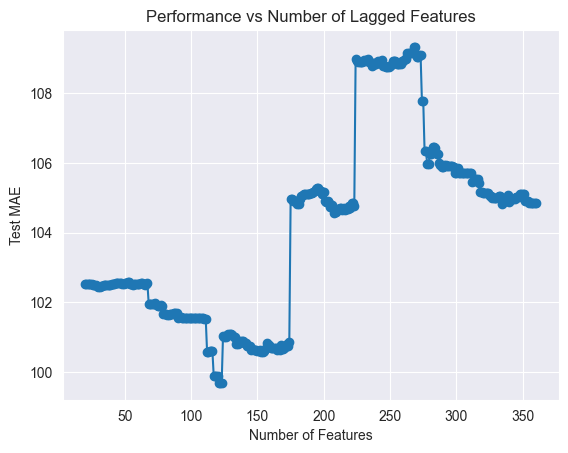

Duration of looping: 1362.5399939999916


In [11]:
results = []
max_features_to_test = 360  # adjust as needed
start = perf_counter()
MINUTE = 3
forecast_horizon = 1 # qh+0 = 0; qh+1 = 1, ...

for n in range(20, max_features_to_test + 1):
    # Take top-n from the ranked list
    selected_feats = tagged_combined[:n]
    qh_parameters, minute_parameters, hour_parameters = build_separated_lag_dicts(
        selected_feats,
        features_with_leads=FEATURES_ALLOW_LEADS,
        features_causal_only=FEATURES_CASUAL_ONLY
    )

    if qh_parameters is None:
        qh_parameters = {"SI": {"lags": [forecast_horizon]}}
    elif "SI" not in qh_parameters:
        qh_parameters["SI"] = {"lags": [forecast_horizon]}
    elif forecast_horizon not in qh_parameters["SI"]["lags"]:
        qh_parameters["SI"]["lags"].append(forecast_horizon)

    if minute_parameters is not None and len(minute_parameters) == 0:
        minute_parameters = None
    if hour_parameters is not None and len(hour_parameters) == 0:
        hour_parameters = None

    # Join data
    df = join_qh_min_data(
        qh_data=qh,
        minute_data=minute,
        qh_parameters=qh_parameters,
        minute_parameters=minute_parameters,
        minute=MINUTE,
        hour_data=hour,
        hour_parameters=hour_parameters
    )

    df = df.dropna()
    df.info(memory_usage="deep", verbose=False)

    # Prepare features and target
    if forecast_horizon == 1:
        TARGET = "SI_from_qh_plus_1"
    elif forecast_horizon == 0:
        TARGET = "SI_current_qh"
    FEATURES = [col for col in df.columns if col != TARGET]

    # Setup time series split
    tscv = TimeSeriesSplit(n_splits=36, max_train_size=4 * 24 * 7 * 20, test_size=4 * 24 * 10, gap=0)
    model = LinearRegression()

    # Run backtesting
    summary, metrics = backtesting_CV_alt(
        model=model,
        data=df,
        time_splits=tscv,
        features=FEATURES,
        target=TARGET,
        use_scaler=True,
        n_jobs=-1,
        return_per_fold=False
    )
    print(metrics)
    # Save results
    results.append({
        "n_features": n,
        **metrics
    })

# Convert to DataFrame for easy plotting or export
import pandas as pd
results_df = pd.DataFrame(results)

# Plot example
import matplotlib.pyplot as plt
plt.figure()
plt.plot(results_df["n_features"], results_df["test_MAE"], marker='o')
plt.xlabel("Number of Features")
plt.ylabel("Test MAE")
plt.title("Performance vs Number of Lagged Features")
plt.grid(True)
plt.show()
print("Duration of looping:", perf_counter() - start)


Frequency identified as: qh
Frequency identified as: minute
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 70040 entries, 2022-01-01 01:03:00+00:00 to 2023-12-31 23:33:00+00:00
Columns: 82 entries, SI_from_qh_minus_1 to aFRR-_min_from_minute_minus_3
dtypes: float64(82)
memory usage: 44.4 MB
{'train_MAE': np.float64(104.21480607833253), 'test_MAE': np.float64(101.56269997979037), 'train_RMSE': np.float64(140.0273149364149), 'test_RMSE': np.float64(136.444285839489), 'train_MAPE': np.float64(307.1263656578916), 'test_MAPE': np.float64(301.39311128912266), 'test_SMAPE': np.float64(-122.98674366473223), 'train_SMAPE': np.float64(-122.77762198959194), 'n_splits': 36, 'total_time_s': 6.09267759998329, 'total_time_fit': np.float64(15.089533567428589), 'total_time_score': np.float64(0.44083285331726074), 'total_fold_cpu_time': np.float64(15.53036642074585), 'efficiency_estimate': np.float64(15.0940557258524)}
Frequency identified as: qh
Frequency identified as: minute
<class 'pandas.core

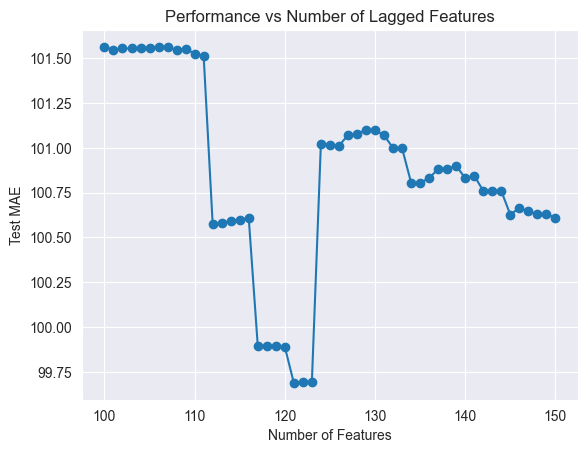

Duration of looping: 166.12795639992692


In [12]:
results = []
max_features_to_test = 150  # adjust as needed
start = perf_counter()
MINUTE = 3
forecast_horizon = 1 # qh+0 = 0; qh+1 = 1, ...

for n in range(100, max_features_to_test + 1):
    # Take top-n from the ranked list
    selected_feats = tagged_combined[:n]
    qh_parameters, minute_parameters, hour_parameters = build_separated_lag_dicts(
        selected_feats,
        features_with_leads=FEATURES_ALLOW_LEADS,
        features_causal_only=FEATURES_CASUAL_ONLY
    )

    if qh_parameters is None:
        qh_parameters = {"SI": {"lags": [forecast_horizon]}}
    elif "SI" not in qh_parameters:
        qh_parameters["SI"] = {"lags": [forecast_horizon]}
    elif forecast_horizon not in qh_parameters["SI"]["lags"]:
        qh_parameters["SI"]["lags"].append(forecast_horizon)

    if minute_parameters is not None and len(minute_parameters) == 0:
        minute_parameters = None
    if hour_parameters is not None and len(hour_parameters) == 0:
        hour_parameters = None

    # Join data
    df = join_qh_min_data(
        qh_data=qh,
        minute_data=minute,
        qh_parameters=qh_parameters,
        minute_parameters=minute_parameters,
        minute=MINUTE,
        hour_data=hour,
        hour_parameters=hour_parameters
    )

    df = df.dropna()
    df.info(memory_usage="deep", verbose=False)

    # Prepare features and target
    if forecast_horizon == 1:
        TARGET = "SI_from_qh_plus_1"
    elif forecast_horizon == 0:
        TARGET = "SI_current_qh"
    FEATURES = [col for col in df.columns if col != TARGET]

    # Setup time series split
    tscv = TimeSeriesSplit(n_splits=36, max_train_size=4 * 24 * 7 * 20, test_size=4 * 24 * 10, gap=0)
    model = LinearRegression()

    # Run backtesting
    summary, metrics = backtesting_CV_alt(
        model=model,
        data=df,
        time_splits=tscv,
        features=FEATURES,
        target=TARGET,
        use_scaler=True,
        n_jobs=-1,
        return_per_fold=False
    )
    print(metrics)
    # Save results
    results.append({
        "n_features": n,
        **metrics
    })

# Convert to DataFrame for easy plotting or export
import pandas as pd
results_df = pd.DataFrame(results)

# Plot example
import matplotlib.pyplot as plt
plt.figure()
plt.plot(results_df["n_features"], results_df["test_MAE"], marker='o')
plt.xlabel("Number of Features")
plt.ylabel("Test MAE")
plt.title("Performance vs Number of Lagged Features")
plt.grid(True)
plt.show()
print("Duration of looping:", perf_counter() - start)
